Epoch 1/10


Loss: 0.0743: 100%|██████████| 469/469 [20:52<00:00,  2.67s/it]


Epoch 2/10


Loss: 0.0734: 100%|██████████| 469/469 [18:09<00:00,  2.32s/it]


Epoch 3/10


Loss: 0.0534: 100%|██████████| 469/469 [17:50<00:00,  2.28s/it]


Epoch 4/10


Loss: 0.0551: 100%|██████████| 469/469 [15:10<00:00,  1.94s/it]


Epoch 5/10


Loss: 0.0446: 100%|██████████| 469/469 [3:38:32<00:00, 27.96s/it]     


Epoch 6/10


Loss: 0.0494: 100%|██████████| 469/469 [21:09<00:00,  2.71s/it]


Epoch 7/10


Loss: 0.0415: 100%|██████████| 469/469 [22:00<00:00,  2.82s/it]


Epoch 8/10


Loss: 0.0438: 100%|██████████| 469/469 [23:10<00:00,  2.97s/it]


Epoch 9/10


Loss: 0.0381: 100%|██████████| 469/469 [22:55<00:00,  2.93s/it]


Epoch 10/10


Loss: 0.0417: 100%|██████████| 469/469 [23:45<00:00,  3.04s/it]


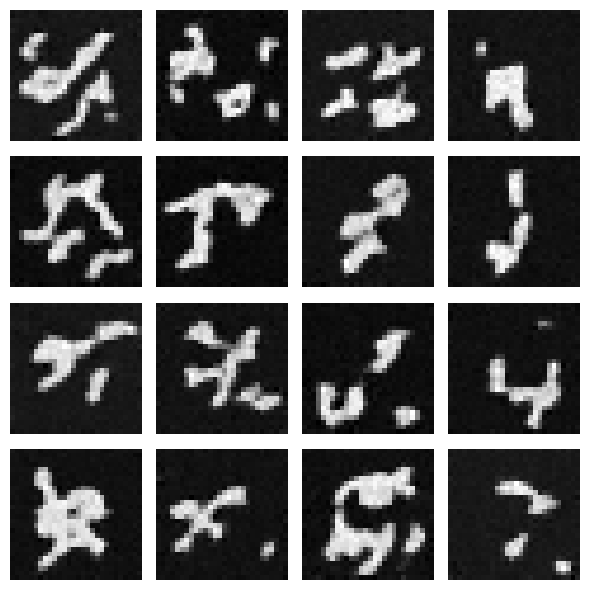

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Data Loading and Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='mnist_data/', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

# 2. Define the Beta Schedule and Precompute Constants
T = 1000
beta_start = 0.0001
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1.0 - beta
alpha_hat = torch.cumprod(alpha, dim=0)

# 3. Define the Model Architecture (U-Net)
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=64):
        super(UNet, self).__init__()

        # Encoder layers
        self.enc1 = nn.Conv2d(in_channels + 1, base_channels, 3, stride=1, padding=1)
        self.enc2 = nn.Conv2d(base_channels, base_channels * 2, 3, stride=2, padding=1)
        self.enc3 = nn.Conv2d(base_channels * 2, base_channels * 4, 3, stride=2, padding=1)

        # Decoder layers
        self.dec1 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 4, stride=2, padding=1)
        self.dec2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 4, stride=2, padding=1)
        self.dec3 = nn.Conv2d(base_channels, out_channels, 3, stride=1, padding=1)

        # BatchNorm layers
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.bn2 = nn.BatchNorm2d(base_channels * 2)
        self.bn3 = nn.BatchNorm2d(base_channels * 4)
        self.bn4 = nn.BatchNorm2d(base_channels * 2)
        self.bn5 = nn.BatchNorm2d(base_channels)

    def forward(self, x, t):
        t = t.float().unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        t = t.repeat(1, 1, x.shape[2], x.shape[3])

        x = torch.cat([x, t], dim=1)

        x1 = F.relu(self.bn1(self.enc1(x)))
        x2 = F.relu(self.bn2(self.enc2(x1)))
        x3 = F.relu(self.bn3(self.enc3(x2)))

        x = F.relu(self.bn4(self.dec1(x3)))
        x = F.relu(self.bn5(self.dec2(x)))
        x = self.dec3(x)

        return x

# 4. Instantiate the Model, Optimizer, and Loss Function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)

# 5. Training Loop
epochs = 10

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    pbar = tqdm(train_loader)
    for images, _ in pbar:
        images = images.to(device)

        t = torch.randint(0, T, (images.size(0),), device=device).long()
        epsilon = torch.randn_like(images).to(device)
        alpha_hat_t = alpha_hat[t].view(-1, 1, 1, 1).to(device)
        x_t = torch.sqrt(alpha_hat_t) * images + torch.sqrt(1 - alpha_hat_t) * epsilon

        t_embed = t / T
        epsilon_theta = model(x_t, t_embed)

        loss = F.mse_loss(epsilon_theta, epsilon)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f'Loss: {loss.item():.4f}')

# 6. Sampling Function
@torch.no_grad()
def sample(model, img_size, n_samples):
    model.eval()
    x_t = torch.randn(n_samples, 1, img_size, img_size).to(device)

    for t in reversed(range(T)):
        t_tensor = torch.full((n_samples,), t, device=device, dtype=torch.long)
        t_embed = t_tensor / T

        epsilon_theta = model(x_t, t_embed)

        beta_t = beta[t].view(-1, 1, 1, 1).to(device)
        alpha_t = alpha[t].view(-1, 1, 1, 1).to(device)
        alpha_hat_t = alpha_hat[t].view(-1, 1, 1, 1).to(device)

        if t > 0:
            z = torch.randn_like(x_t).to(device)
        else:
            z = 0

        x_t = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / torch.sqrt(1 - alpha_hat_t)) * epsilon_theta) + torch.sqrt(beta_t) * z

    x_0 = x_t
    return x_0

# 7. Generate and Visualize Samples
n_samples = 16
img_size = 28

samples = sample(model, img_size, n_samples)
samples = samples.cpu().numpy()
samples = (samples + 1) / 2

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i][0], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()
